# Using the Zarr Tile Sink

The `ZarrFileTileSource` class has file-writing capabilities; an empty image can be created, image data can be added as tiles or arbitrary regions, and the image can be saved to a file in any of several formats.

Typically, this class is called a "source" when reading from a file and a "sink" when writing to a file. This is just a naming convention, but the read mode and write mode are not mutually exclusive.

## Installation

In [1]:
# This will install large_image with the zarr source
!pip install large_image[tiff,zarr,converter] --find-links https://girder.github.io/large_image_wheels

# For maximum capabilities in Jupyter, also install ipyleaflet so you can
# view zoomable images in the notebook
!pip install ipyleaflet

In [2]:
# Ask JupyterLab to locally proxy an internal tile server
import importlib.util
import large_image

if importlib.util.find_spec('google') and importlib.util.find_spec('google.colab'):
    # colab intercepts localhost
    large_image.tilesource.jupyter.IPyLeafletMixin.JUPYTER_PROXY = 'https://localhost'
else:
    large_image.tilesource.jupyter.IPyLeafletMixin.JUPYTER_PROXY = True

## Sample Data Download

For this example, we will use data from a sample file. We will copy and modify tiles from this image, writing the modified data to a new file.

In [2]:
!curl -L -C - -o example.tiff https://demo.kitware.com/histomicstk/api/v1/item/58b480ba92ca9a000b08c899/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.3M  100 12.3M    0     0  2952k      0  0:00:04  0:00:04 --:--:-- 2952k


In [3]:
original_image_path = 'example.tiff'
processed_image_path = 'processed_example_1.tiff'

source = large_image.open(original_image_path)

# view the metadata
source_metadata = source.getMetadata()
source_metadata

{'levels': 7,
 'sizeX': 9216,
 'sizeY': 11264,
 'tileWidth': 256,
 'tileHeight': 256,
 'magnification': 40.0,
 'mm_x': 0.00025,
 'mm_y': 0.00025,
 'dtype': 'uint8',
 'bandCount': 3}

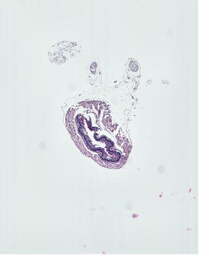

In [4]:
# show source as a static thumbnail
source.getThumbnail()[0]

In [5]:
# show the source image in an interactive viewer
source

## Writing Processed Data to a New File

In [7]:
from skimage.color.adapt_rgb import adapt_rgb, hsv_value
from skimage import filters

# define some image processing function

@adapt_rgb(hsv_value)
def process_tile(tile, footprint_size):
    return filters.unsharp_mask(
        tile, radius=footprint_size,
    )

In [7]:
# create a sink, which is an instance of ZarrFileTileSource and has no data
sink = large_image.new()

# compare three different footprint sizes for processing algorithm
# computing the processed image takes about 1 minute for each value
footprint_sizes = [1, 10, 50]
print(f'Processing image for {len(footprint_sizes)} frames.')

# create a frame for each processed result
for i, footprint_size in enumerate(footprint_sizes):
    print('Processing image with footprint_size = ', footprint_size)
    # iterate through tiles, getting numpy arrays for each tile
    for tile in source.tileIterator(format='numpy'):
        # for each tile, run some processing algorithm
        t = tile['tile']
        processed_tile = process_tile(t, footprint_size) * 255

        # add modified tile to sink
        # specify tile x, tile y, and any arbitrary frame parameters
        sink.addTile(processed_tile, x=tile['x'], y=tile['y'], footprint=i, footprint_value=footprint_size)
# view metadata
sink.getMetadata()

Processing image for 3 frames.
Processing image with footprint_size =  1
Processing image with footprint_size =  10
Processing image with footprint_size =  50


{'levels': 6,
 'sizeX': 9216,
 'sizeY': 11264,
 'tileWidth': 512,
 'tileHeight': 512,
 'magnification': None,
 'mm_x': 0,
 'mm_y': 0,
 'dtype': 'float64',
 'bandCount': 3,
 'frames': [{'Frame': 0,
   'IndexFOOTPRINT': 0,
   'ValueFOOTPRINT': 1,
   'Index': 0,
   'Channel': 'Band 1'},
  {'Frame': 1,
   'IndexFOOTPRINT': 1,
   'ValueFOOTPRINT': 10,
   'Index': 1,
   'Channel': 'Band 1'},
  {'Frame': 2,
   'IndexFOOTPRINT': 2,
   'ValueFOOTPRINT': 50,
   'Index': 2,
   'Channel': 'Band 1'}],
 'ValueFOOTPRINT': {'values': [1, 10, 50],
  'uniform': True,
  'units': None,
  'min': 1,
  'max': 50,
  'datatype': 'int64'},
 'IndexRange': {'IndexFOOTPRINT': 3},
 'IndexStride': {'IndexFOOTPRINT': 1},
 'channels': ['Band 1'],
 'channelmap': {'Band 1': 0}}

In [8]:
# show the result image in an interactive viewer
# the viewer includes a slider for this multiframe image
# switch between frames to view the differences between the values passed to footprint_size
sink

## Edit Attributes and Write Result File

In [9]:
# set crop bounds
sink.crop = (3000, 5000, 2048, 2048)

# set mm_x and mm_y from source metadata
sink.mm_x = source_metadata.get('mm_x')
sink.mm_y = source_metadata.get('mm_y')

# set image description
sink.imageDescription = 'processed with scikit-image'

# add original thumbnail as an associated image
sink.addAssociatedImage(source.getThumbnail()[0], imageKey='original')

# write new image as tiff (other format options include .zip, .zarr, .db, .sqlite, .svs, etc.)
sink.write(processed_image_path)

## View Results

In [10]:
# open written file as a new source
# this will be opened as a TiffFileTileSource
source_2 = large_image.open(processed_image_path)

# view metadata
source_2.getMetadata()

{'levels': 4,
 'sizeX': 2048,
 'sizeY': 2048,
 'tileWidth': 256,
 'tileHeight': 256,
 'magnification': None,
 'mm_x': None,
 'mm_y': None,
 'dtype': 'uint16',
 'bandCount': 3,
 'frames': [{'Channel': 'Band 1', 'Frame': 0, 'Index': 0, 'IndexFOOTPRINT': 0},
  {'Channel': 'Band 1', 'Frame': 1, 'Index': 1, 'IndexFOOTPRINT': 1},
  {'Channel': 'Band 1', 'Frame': 2, 'Index': 2, 'IndexFOOTPRINT': 2}],
 'IndexRange': {'IndexFOOTPRINT': 3},
 'IndexStride': {'IndexFOOTPRINT': 1},
 'channels': ['Band 1'],
 'channelmap': {'Band 1': 0}}

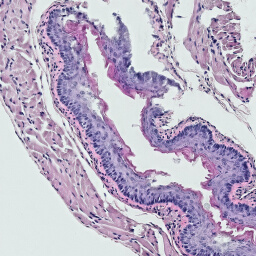

In [11]:
# show source_2 as a static thumbnail
source_2.getThumbnail()[0]

In [12]:
# show source_2 in an interactive viewer
source_2